<b>import necessary files </b>

In [1]:
#tensorflow as open source end to end open source platform
import tensorflow as tf

#import necessary layers for the model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense

#import functions that are relevent for the model
from tensorflow.keras.models import Model, load_model

#import saving instance of states and checkpoints meanwhile that is training 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

#use to separate the data for train, test and validate
from sklearn.model_selection import train_test_split

#for statictical analysis 
from sklearn.metrics import f1_score

#to shuffle the data to spread the non tumorous and tumourous 
from sklearn.utils import shuffle

#use computer vision 
import cv2

#for basic image manipulation
import imutils

#create arrays
import numpy as np

#plot the relevent data
import matplotlib.pyplot as plt

#for calculations of time
import time

#for file handling 
from os import listdir

<b>Augment the collection of data using following function</b>
<br><br>
Here in the function<br>
<ol>
    <li> Convert the image into black and white image. This will reduct the variations due to the color to reduce to extra dimentions. </li>
    <li>Apply a Gausian blur filter to blur the image for further reduct the sharped unecessary things.</li>
    <li>Apply three threshold filters to reduce the noises in the picture.</li>
    <li>Detect contours and grab the largest one (this is for cropping if it requires).</li> 
    <li>(optional) if keep on cropping fifth would be to record the extreame points of the image.</li>
    <li> Then create the image as new_image in the function</li>    
</ol>

In [10]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    #extLeft = tuple(c[c[:, :, 0].argmin()][0])
    #extRight = tuple(c[c[:, :, 0].argmax()][0])
    #extTop = tuple(c[c[:, :, 1].argmin()][0])
    #extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    #new_image = thresh[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(thresh)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return thresh

<b>Run the function crop_brain_countour and see the result below</b>

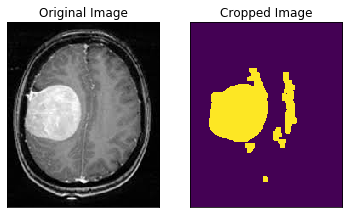

In [11]:
#use an example to view the crop

ex_img = cv2.imread('165566_377107_bundle_archive/brain_tumor_dataset/yes/Y1.jpg')

ex_new_img = crop_brain_contour(ex_img, True)

<b>This load_data function import all data and apply crop_retino_contour function for each image then add them into numpy array with their label</b>

<ol>
    <li>First import and read the image using imread.</li>
    <li>Second apply crop brain contour function for each image.</li>
    <li>Third resize the image to a 240 x 240 image because the imput to the model should be exactly same.</li>
    <li>Forth normalize those pixel values in the image between 0 and 1 for the efficient the training model</li>
    <li>Fifth the labeled data created as an binary using to_categorical.</li>
    <li>Sixth the data of images added to X as a matrix and all the labels added to y as a matrix </li>
    <li>Seventh all the data in X and y are shuffled</li>
    <li>Print the necessary image data on both matrices</li>
</ol>

In [12]:
#import all the necessary data to the x and y array

def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory == '165566_377107_bundle_archive/brain_tumor_dataset/yes1':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

<b>Define the file paths </b><br>
<p>yes1 is the folder that contains the brain tumour pictures</p>
<p>no1 is the folder that contains the tumor free pictures</p>

In [13]:
augmented_path = '165566_377107_bundle_archive/brain_tumor_dataset/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes1' 
augmented_no = augmented_path + 'no1'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2473
X shape is: (2473, 240, 240)
y shape is: (2473, 1)


<b>Define plot sample images as a function to see the overall dataset when the above functions are applied</b>

In [14]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

<b>Run the sample image preview function</b>

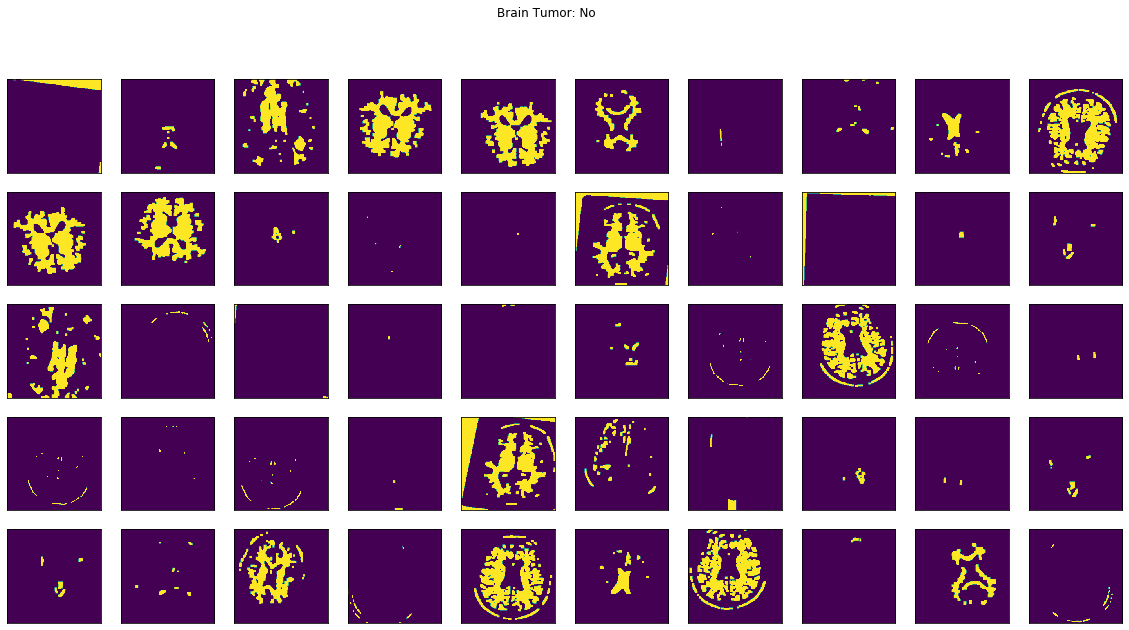

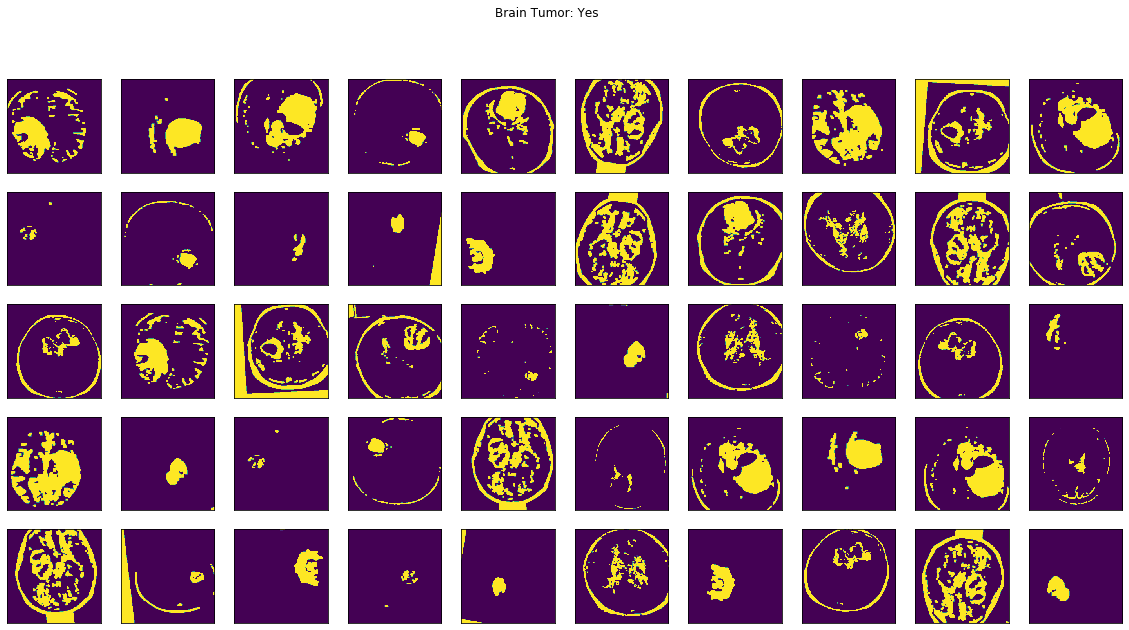

In [310]:
plot_sample_images(X, y)

<b>Split data into train, test and validade</b>

In [15]:
def split_data(X, y, test_size=0.2):    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test


<b>X array dimentions are enhanced by one factor to apply CNN layers to the model</b>

In [17]:
X = np.reshape(X, (2473, 240, 240 ,1))
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

<b>The summary of the programme so far given below</b>

In [18]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1731
number of development examples = 371
number of test examples = 371
X_train shape: (1731, 240, 240, 1)
Y_train shape: (1731, 1)
X_val (dev) shape: (371, 240, 240, 1)
Y_val (dev) shape: (371, 1)
X_test shape: (371, 240, 240, 1)
Y_test shape: (371, 1)


<b>Timing function</b>

In [19]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

<b>Function for the building the model of the progrramme</b>

In [20]:
def build_model(input_shape):

    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

<b>Run the function build_model by using a given image shape and dimensions</b>

In [21]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)
model = build_model(IMG_SHAPE)

In [22]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 1)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      1600      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

<b>COmpile the model using optimizer as adam and use binary crossentropy for loss calculation</b>

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<b>Run the model for training the given dataset</b>

In [24]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Train on 1731 samples, validate on 371 samples
Epoch 1/10
1731/1731 [==============================] - 89s 51ms/sample - loss: 0.8574 - accuracy: 0.6210 - val_loss: 0.6345 - val_accuracy: 0.6900
Epoch 2/10
1731/1731 [==============================] - 89s 51ms/sample - loss: 0.6414 - accuracy: 0.6967 - val_loss: 0.6261 - val_accuracy: 0.7251
Epoch 3/10
1731/1731 [==============================] - 90s 52ms/sample - loss: 0.5959 - accuracy: 0.7071 - val_loss: 0.5994 - val_accuracy: 0.7143
Epoch 4/10
1731/1731 [==============================] - 88s 51ms/sample - loss: 0.6101 - accuracy: 0.7094 - val_loss: 0.5887 - val_accuracy: 0.7035
Epoch 5/10
1731/1731 [==============================] - 90s 52ms/sample - loss: 0.6202 - accuracy: 0.7135 - val_loss: 0.6868 - val_accuracy: 0.6173
Epoch 6/10
1731/1731 [==============================] - 93s 54ms/sample - loss: 0.5093 - accuracy: 0.7597 - val_loss: 0.6060 - val_accuracy: 0.6712
Epoch 7/10
1731/1731 [==============================] - 96s 56ms/

<b> Plot the summary of the training with the variation of the accuracy and the loss</b>

In [25]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


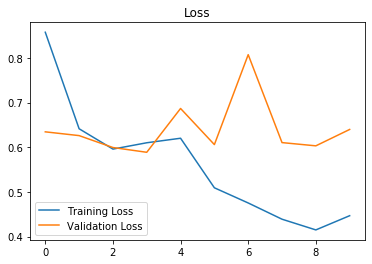

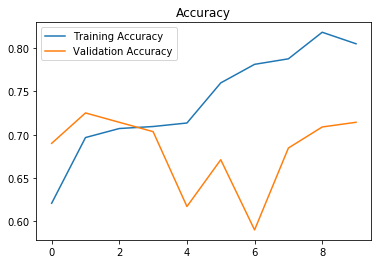

In [28]:
plot_metrics(history)

<b>Save the created model weights </b>

In [29]:
model.save_weights('BTD.h5')


<b>Evaluate the created model</b>

In [30]:
model.evaluate(X_test,y_test)

371/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.719357307709131, 0.67654985]

<b>Save the created model</b>

In [31]:
model.save('saved_model.h5')

<b>Load the model</b>

In [32]:
loaded_model = load_model('saved_model.h5')

<b>Define predict if tumor function to see result if uploaded a given image</b>

In [33]:
def predict_if_tumor(file_name):
    img = cv2.imread('sample_test/' + file_name)
    img = crop_brain_contour(img, plot=True)
    img = cv2.resize(img, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    img = img / 255.
    im = []

    im.append(img)
    im = np.array(im)
    im = np.reshape(im, (1, 240, 240, 1))
    pre = loaded_model.predict(im)
    pre = pre*100
    
    print('The Probability of having a brain tumor is ' + str(pre[0][0]) + '%.')

<b>Running the predict if tumor function</b>

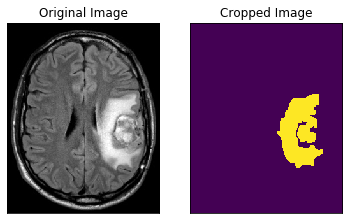

The Probability of having a brain tumor is 64.089355%.


In [40]:
predict_if_tumor('Y20.jpg')